In [ ]:
# install rdkit
!wget -c https://repo.continuum.io/miniconda/Miniconda3-py37_4.8.3-Linux-x86_64.sh
!chmod +x Miniconda3-py37_4.8.3-Linux-x86_64.sh
!time bash ./Miniconda3-py37_4.8.3-Linux-x86_64.sh -b -f -p /usr/local
!time conda install -q -y -c conda-forge rdkit==2020.09.2

--2022-12-28 23:59:36--  https://repo.continuum.io/miniconda/Miniconda3-py37_4.8.3-Linux-x86_64.sh
Resolving repo.continuum.io (repo.continuum.io)... 104.18.200.79, 104.18.201.79, 2606:4700::6812:c94f, ...
Connecting to repo.continuum.io (repo.continuum.io)|104.18.200.79|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://repo.anaconda.com/miniconda/Miniconda3-py37_4.8.3-Linux-x86_64.sh [following]
--2022-12-28 23:59:36--  https://repo.anaconda.com/miniconda/Miniconda3-py37_4.8.3-Linux-x86_64.sh
Resolving repo.anaconda.com (repo.anaconda.com)... 104.16.130.3, 104.16.131.3, 2606:4700::6810:8303, ...
Connecting to repo.anaconda.com (repo.anaconda.com)|104.16.130.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 88867207 (85M) [application/x-sh]
Saving to: ‘Miniconda3-py37_4.8.3-Linux-x86_64.sh’

Miniconda3-py37_4.8 100%[===================>]  84.75M  39.4MB/s    in 2.1s    

2022-12-28 23:59:39 (39.4 MB/s) - ‘Minico

In [ ]:
# import core libraries 
import sys
import os
import pandas as pd
import numpy as np
import json
from sklearn.model_selection import train_test_split

sys.path.append('/usr/local/lib/python3.7/site-packages/')
from rdkit import Chem
from rdkit.Chem import Draw, Descriptors
import random as rn
import matplotlib.pyplot as plt
%matplotlib inline

%tensorflow_version 2.x
import tensorflow as tf
print("TensorFlow version:", tf.__version__)

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
TensorFlow version: 2.9.2


In [ ]:
# load Keras libraries
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, Concatenate
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, TensorBoard
from tensorflow.keras.utils import Sequence

In [ ]:

# enable GPU processing
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Found GPU at: /device:GPU:0
Thu Dec 29 00:15:14 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    25W /  70W |    312MiB / 15109MiB |      1%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                            

In [ ]:
# set random seed
seed = 777
np.random.seed(seed)
rn.seed(seed)
np.seterr(divide='ignore')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [ ]:
# mount Google Drive
from google.colab import drive
drive.mount('/drive')

Mounted at /drive


In [ ]:
# load the model
model_file = '/drive/My Drive/chem_data/LSTM_model.h5'
model = load_model(model_file)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 100, 45)]    0           []                               
                                                                                                  
 lstm (LSTM)                    [(None, 256),        309248      ['input_1[0][0]']                
                                 (None, 256),                                                     
                                 (None, 256)]                                                     
                                                                                                  
 concatenate (Concatenate)      (None, 512)          0           ['lstm[0][1]',                   
                                                                  'lstm[0][2]']               

In [ ]:
# create data load functions
def load_data(data):
    with open(data, 'r') as f:
        smiles = [r.rstrip() for r in f]
    return np.array(smiles)

def load_dictionaries(input_dict):
    with open(input_dict, 'r') as fp:
        new_dict = json.load(fp)
    return new_dict 

In [ ]:

# load transfer learning dataset 
smifile = '/drive/My Drive/chem_data/nextgen_smiles.smi'
data = load_data(smifile)
print("Training dataset shape:", data.shape)
print("Sample training smile: \n", data[2])

Training dataset shape: (100,)
Sample training smile: 
 NC1CC(O)C23CCC1C2Cc1c2cc[n+](nc(cnc1C=O)C3)CC1=CC=C(C=C2)N(N)O1


In [ ]:

# load the Python dictionaries that map characters-to-integers and intergers-to-characters
d1 = '/drive/My Drive/chem_data/char_to_int.json'
d2 = '/drive/My Drive/chem_data/int_to_char.json'
char_to_int = load_dictionaries(d1)
int_to_char = load_dictionaries(d2)
n_vocab = len(char_to_int)
print("Character set vocabulary length:", n_vocab)
print("Dictionary mapping characters-to-integers:\n", char_to_int)
print("Dictionary mapping integers-to-characters:\n", int_to_char)

Character set vocabulary length: 45
Dictionary mapping characters-to-integers:
 {'n': 0, '[': 1, '\\': 2, 'E': 3, 'H': 4, ')': 5, 'B': 6, '9': 7, '2': 8, ']': 9, '7': 10, '!': 11, 't': 12, 's': 13, 'o': 14, 'c': 15, 'K': 16, '-': 17, '/': 18, 'l': 19, 'A': 20, 'r': 21, '@': 22, 'C': 23, '=': 24, '6': 25, 'N': 26, 'L': 27, 'a': 28, '5': 29, 'S': 30, 'T': 31, '#': 32, '+': 33, 'P': 34, 'i': 35, '(': 36, '8': 37, '1': 38, 'I': 39, 'e': 40, 'O': 41, '3': 42, 'F': 43, '4': 44}
Dictionary mapping integers-to-characters:
 {'0': 'n', '1': '[', '2': '\\', '3': 'E', '4': 'H', '5': ')', '6': 'B', '7': '9', '8': '2', '9': ']', '10': '7', '11': '!', '12': 't', '13': 's', '14': 'o', '15': 'c', '16': 'K', '17': '-', '18': '/', '19': 'l', '20': 'A', '21': 'r', '22': '@', '23': 'C', '24': '=', '25': '6', '26': 'N', '27': 'L', '28': 'a', '29': '5', '30': 'S', '31': 'T', '32': '#', '33': '+', '34': 'P', '35': 'i', '36': '(', '37': '8', '38': '1', '39': 'I', '40': 'e', '41': 'O', '42': '3', '43': 'F', '44

In [ ]:
# create a function to turn the dataset into a supervised problem, add the beginning and ending character markers, 
# add padding for constant sequence length, and turn the sequence into a sequence of one-hot vectors
def vectorize(smiles, embed, n_vocab):
    one_hot = np.zeros((smiles.shape[0], embed, n_vocab), dtype=np.int8)
    for i, smile in enumerate(smiles):
        # encode the start
        one_hot[i,0,char_to_int["!"]] = 1
        #encode the smiles characters
        for j, c in enumerate(smile):
            one_hot[i,j+1,char_to_int[c]] = 1
        # encode the end of the smiles string
        one_hot[i,len(smile)+1:,char_to_int["E"]] = 1
    # return two items, one for input and one for output
    return one_hot[:,0:-1,:], one_hot[:,1:,:]

In [ ]:
# create our X & y dataset
embed = 101
X_train, y_train = vectorize(data, embed, n_vocab)
print("Training input shape:", X_train.shape)
print("Training output shape:", y_train.shape)

Training input shape: (100, 100, 45)
Training output shape: (100, 100, 45)


In [ ]:
# train the model on the transfer learning dataset
batch_size = 16
nb_epochs = 225 // 4
model.fit([X_train, X_train], y_train, epochs=nb_epochs, batch_size=batch_size)

Epoch 1/56
7/7 [==============================] - 7s 22ms/step - loss: 2.1695 - acc: 0.6299
Epoch 2/56
7/7 [==============================] - 0s 20ms/step - loss: 1.5971 - acc: 0.6430
Epoch 3/56
7/7 [==============================] - 0s 15ms/step - loss: 1.2442 - acc: 0.6724
Epoch 4/56
7/7 [==============================] - 0s 15ms/step - loss: 1.0039 - acc: 0.7003
Epoch 5/56
7/7 [==============================] - 0s 16ms/step - loss: 0.8342 - acc: 0.7329
Epoch 6/56
7/7 [==============================] - 0s 15ms/step - loss: 0.7286 - acc: 0.7643
Epoch 7/56
7/7 [==============================] - 0s 14ms/step - loss: 0.6594 - acc: 0.7845
Epoch 8/56
7/7 [==============================] - 0s 15ms/step - loss: 0.5923 - acc: 0.8037
Epoch 9/56
7/7 [==============================] - 0s 14ms/step - loss: 0.5330 - acc: 0.8232
Epoch 10/56
7/7 [==============================] - 0s 14ms/step - loss: 0.4960 - acc: 0.8344
Epoch 11/56
7/7 [==============================] - 0s 15ms/step - loss: 0.4511 

In [ ]:

# save our transfer learning model & weights
mod_file = '/drive/My Drive/chem_data/LSTM_transfer_model.h5'
model.save(mod_file)
print("Model Saved")


Model Saved


In [ ]:
# create the encoder model from the previously trained model
encoder_model = Model(inputs=model.layers[0].input, outputs=model.layers[3].output)
encoder_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 100, 45)]    0           []                               
                                                                                                  
 lstm (LSTM)                    [(None, 256),        309248      ['input_1[0][0]']                
                                 (None, 256),                                                     
                                 (None, 256)]                                                     
                                                                                                  
 concatenate (Concatenate)      (None, 512)          0           ['lstm[0][1]',                   
                                                                  'lstm[0][2]']               

In [ ]:
# create a model for mapping from the latent space to the input states of the decoder LSTM model
latent_input = Input(shape=(128, ))
state_h = model.layers[5](latent_input)
state_c = model.layers[6](latent_input)
latent_to_states_model = Model(latent_input, [state_h, state_c])
latent_to_states_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128)]        0           []                               
                                                                                                  
 dense_1 (Dense)                (None, 256)          33024       ['input_1[0][0]']                
                                                                                                  
 dense_2 (Dense)                (None, 256)          33024       ['input_1[0][0]']                
                                                                                                  
Total params: 66,048
Trainable params: 66,048
Non-trainable params: 0
__________________________________________________________________________________________________


In [ ]:
# define the stateful decoder model
decoder_inputs = Input(batch_shape=(1, 1, 45))
decoder_lstm = LSTM(256, return_sequences=True, stateful=True)(decoder_inputs)
decoder_outputs = Dense(45, activation='softmax')(decoder_lstm)
gen_model = Model(decoder_inputs, decoder_outputs)

In [ ]:

# transfer the weights from the transfer learning model to our generative model
for i in range(1,3):
    gen_model.layers[i].set_weights(model.layers[i+6].get_weights())
gen_model.save("/drive/My Drive/chem_data/gen_model.h5")
gen_model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(1, 1, 45)]              0         
                                                                 
 lstm (LSTM)                 (1, 1, 256)               309248    
                                                                 
 dense (Dense)               (1, 1, 45)                11565     
                                                                 
Total params: 320,813
Trainable params: 320,813
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# create our Softmax sampling function 
def sample_with_temp(preds, sampling_temp):
    streched = np.log(preds) / sampling_temp
    streched_probs = np.exp(streched) / np.sum(np.exp(streched))
    return np.random.choice(range(len(streched)), p=streched_probs)

In [ ]:
# create a function to generate new smiles from the latent space
def sample_smiles(latent, n_vocab, sampling_temp):
    #decode the latent states and set the initial state of the LSTM cells
    states = latent_to_states_model.predict(latent)
    gen_model.layers[1].reset_states(states=[states[0], states[1]])
    # define the input character
    startidx = char_to_int["!"]
    samplevec = np.zeros((1,1,n_vocab))
    samplevec[0,0,startidx] = 1
    sequence = ""
    # loop to predict the next smiles character
    for i in range(101):
        preds = gen_model.predict(samplevec)[0][-1]
        if sampling_temp == 1.0:
          sampleidx = np.argmax(preds)
        else:
          sampleidx = sample_with_temp(preds, sampling_temp)
        samplechar = int_to_char[str(sampleidx)]
        if samplechar != "E":
            sequence += samplechar
            samplevec = np.zeros((1,1,n_vocab))
            samplevec[0,0,sampleidx] = 1
        else:
            break
    return sequence 

In [ ]:
# create the latent space
latent_space = encoder_model.predict(X_train)
print(f'Latent space shape: {latent_space.shape}')

4/4 [==============================] - 0s 5ms/step
Latent space shape: (100, 128)


In [ ]:
# smile generation from the latent space using a baseline sampling temp
sampling_temp = 1.0
test_smile = sample_smiles(latent_space[0:1], n_vocab, sampling_temp)
print('Baseline sampling temp smile generation:')
print(test_smile)
print(data[0])

1/1 [==============================] - 0s 16ms/step
Baseline sampling temp smile generation:
COC1c2cccc(c2)C(C)c2ccsc2NC(=O)C2C3CCC4C5C6=C(N)C=CC=C7C(OS(C)(=O)=O)=CC=C6N(C3N(C)C4CO)C71C52
COC1c2cccc(c2)C(C)c2ccsc2NC(=O)C2C3CCC4C5C6=C(N)C=CC=C7C(OS(C)(=O)=O)=CC=C6N(C3N(C)C4CO)C71C52


In [ ]:
# smile generation from the latent space using a more aggressive sampling temp
sampling_temp = 1.25
test_smile = sample_smiles(latent_space[0:1], n_vocab, sampling_temp)
print(test_smile)
print(data[0])

1/1 [==============================] - 0s 17ms/step
COC1c2cccc(c2)C(C)c2conc2NC(=O)C2C3c4ccccc4C(=O)N=CC(=C2=N)N3)C2CC=CNC(=O)C(=O)N(C)C12C=CC=S3O
COC1c2cccc(c2)C(C)c2ccsc2NC(=O)C2C3CCC4C5C6=C(N)C=CC=C7C(OS(C)(=O)=O)=CC=C6N(C3N(C)C4CO)C71C52


In [ ]:
# check percentage of malformed smiles generated using a baseline sampling temperature
sampling_temp = 1.0
wrong = 0
for i in range(100):
    smiles = sample_smiles(latent_space[i:i+1], n_vocab, sampling_temp)
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        pass
    else: 
        wrong = wrong + 1
print("%0.1F percent wrongly formatted smiles"%(wrong/float(100)*100)) 

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 21ms/step
18.0 percent wrongly formatted smiles


In [ ]:
# function to generate smiles around a latent vector
def generate(latent_seed, sampling_temp, scale, quant):
  samples, mols = [], []
  for i in range(quant):
    latent_vec = latent_seed + scale*(np.random.randn(latent_seed.shape[1]))
    out = sample_smiles(latent_vec, n_vocab, sampling_temp)
    mol = Chem.MolFromSmiles(out)
    if mol:
      mols.append(mol)
      samples.append(out)
  return mols, samples

1/1 [==============================] - 0s 18ms/step


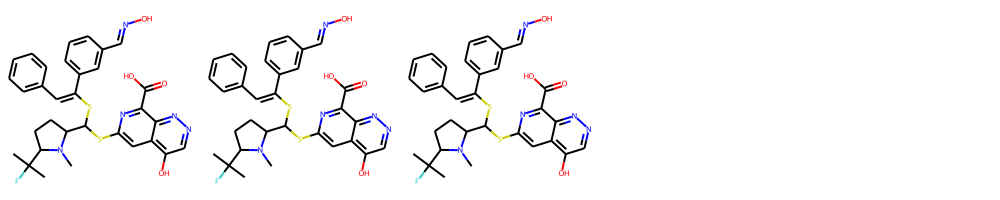

In [ ]:
# generate and plot our generated smiles molecules
latent_seed = latent_space[50:51]
sampling_temp = 0.75
scale = 0.5
quantity = 20
t_mols, t_smiles = generate(latent_seed, sampling_temp, scale, quantity)
Draw.MolsToGridImage(t_mols, molsPerRow=5)

In [ ]:
print(f'Sampled SMILES:\n {t_smiles}')

Sampled SMILES:
 ['CN1C(C(SC(=Cc2ccccc2)c2cccc(C=NO)c2)Sc2cc3c(O)cnnc3c(C(=O)O)n2)CCC1C(C)(C)F', 'CN1C(C(SC(=Cc2ccccc2)c2cccc(C=NO)c2)Sc2cc3c(O)cnnc3c(C(=O)O)n2)CCC1C(C)(C)F', 'CN1C(C(SC(=Cc2ccccc2)c2cccc(C=NO)c2)Sc2cc3c(O)cnnc3c(C(=O)O)n2)CCC1C(C)(C)F']


In [ ]:
# create a for loop to generate molecules based off our sampling dataset's latent space
gen_mols, gen_smiles = [], []
for i in range(latent_space.shape[0] - 1):
  latent_seed = latent_space[i:i+1]
  sampling_temp = rn.uniform(0.75, 1.26)
  scale = 0.75
  quantity = 50
  mols, smiles = generate(latent_seed, sampling_temp, scale, quantity)
  gen_mols.extend(mols)
  gen_smiles.extend(smiles)
  moles, smiles = [], []
print('SMILES generation completed!')

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 28ms/step


In [ ]:
# save the generated smiles list
outfile = '/drive/My Drive/chem_data/generated_smiles_nextgen_v1.csv'
with open(outfile, 'w') as f:
    for smi in gen_smiles:
        f.write(smi + '\n')
print('SMILES saved')